<a href="https://colab.research.google.com/github/danigallegdup/NUS-Stock-Data/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction using LSTM
This project aims to predict stock prices using historical data and Long Short-Term Memory (LSTM) neural networks.

## Data Loading and Preprocessing

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


In [59]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Load the dataset (had to make a shortcut from "Shared with Me" to MyDrive)
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

In [61]:
# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]


In [62]:
# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

# Replace the original sp500 DataFrame with the modified one
sp500 = new_sp500
sp500

<ipython-input-62-90077ebfbdb0>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)


,Date,Price,Type of Price
0,2005-02-25,104.770,open
1,2005-02-25,105.340,average
2,2005-02-25,105.790,close
3,2005-02-28,105.550,open
4,2005-02-28,105.120,average
...,...,...,...
9598,2017-11-09,257.375,average
9599,2017-11-09,258.170,close
9600,2017-11-10,257.730,open
9601,2017-11-10,257.790,average


## Neural Network Architecture

References: To put in our presentation or somewhere later <br>
https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/ <br>
https://www.coursera.org/in/articles/types-of-neural-networks

In our project, we decided to utilise Long short-term memory (LSTM) networks. LSTMs are a specialised type of recurrent neural network architecture, specifically designed to remember information over extended periods of time. This makes them the perfect model to use for our time-series data.


Originally use 'Close' price as we deduced it as most relevant and stable data and introduce the least amount of noise. But now I that I think of it that could be the main reason it is overfitting lol

In [63]:
print(sp500) # test case

scaler = MinMaxScaler(feature_range=(-1, 1))
sp500['Price'] = scaler.fit_transform(sp500['Price'].values.reshape(-1, 1))

            Date    Price Type of Price
0     2005-02-25  104.770          open
1     2005-02-25  105.340       average
2     2005-02-25  105.790         close
3     2005-02-28  105.550          open
4     2005-02-28  105.120       average
...          ...      ...           ...
9598  2017-11-09  257.375       average
9599  2017-11-09  258.170         close
9600  2017-11-10  257.730          open
9601  2017-11-10  257.790       average
9602  2017-11-10  258.090         close

[9603 rows x 3 columns]


## Normalizing the Data

In [64]:

# Initialize the MinMaxScaler with a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the 'Price' column and transform the data
# Reshape to (-1, 1) because the scaler expects a 2D array
sp500['Price'] = scaler.fit_transform(sp500['Price'].values.reshape(-1, 1))

# Now, split the scaled data into training and testing sets
data = sp500['Price'].values
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size - 10:]  # Include overlap for sequence creation

# After creating predictions, use the scaler to revert them back to the original scale:
# predictions_rescaled = scaler.inverse_transform(predictions)
# actuals_rescaled = scaler.inverse_transform(actuals)


In [65]:
# Convert predictions and actual values back to their original scale
predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actuals_rescaled = scaler.inverse_transform(np.array(test_data[10:]).reshape(-1, 1))  # Adjust for the overlap


## Prepare Dataset for PyTorch

In [66]:

class StockDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # The length is reduced by the sequence length to avoid out-of-bound errors
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Get a sequence of prices and the next price as the label
        x = self.data[index:index + self.seq_length]  # Sequence input
        y = self.data[index + self.seq_length]  # Label (next value in sequence)

        # Convert to PyTorch tensors and reshape x to (seq_length, 1)
        x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y


In [67]:
# Define the sequence length (e.g., 10 for predicting based on 10 days of past data)
seq_length = 10

# Create training and testing datasets
train_dataset = StockDataset(train_data, seq_length=seq_length)
test_dataset = StockDataset(test_data, seq_length=seq_length)

# Create DataLoaders for training and testing datasets
# Batch size is set to 64 for training, adjust based on memory capacity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Define LSTM Model

In [68]:

class LSTMStockPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define two LSTM layers with 50 units each
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True)

        # Define a linear layer to map the LSTM outputs to the desired output size
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Pass the input sequence through the LSTM layers
        lstm_out, _ = self.lstm(input_seq)  # lstm_out: [batch_size, seq_length, hidden_layer_size]

        # Take the output of the last time step (seq_length - 1)
        lstm_out = lstm_out[:, -1, :]  # Shape: [batch_size, hidden_layer_size]

        # Pass the output through the linear layer to get the final prediction
        predictions = self.linear(lstm_out)  # Shape: [batch_size, output_size]

        return predictions


In [69]:
# Initialize the model
model = LSTMStockPredictor(input_size=1, hidden_layer_size=50, output_size=1)

# Define the loss function (Mean Squared Error)
loss_function = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted as needed


## Train the Model

In [70]:
# Set the model to training mode
model.train()

# Define the number of epochs for training
epochs = 100  # Adjust as needed based on convergence

# Iterate over epochs for training
for epoch in range(epochs):
    epoch_loss = 0  # To keep track of the cumulative loss for the epoch

    # Loop through batches of data from the DataLoader
    for seq, labels in train_loader:
        optimizer.zero_grad()  # Clear the gradients from the previous step

        # Reshape seq to have dimensions (batch_size, seq_length, input_size)
        seq = seq.view(-1, seq_length, 1)  # Adjust shape for LSTM input

        # Forward pass: get predictions from the model
        y_pred = model(seq)

        # Calculate the loss between the predicted and actual values
        loss = loss_function(y_pred, labels.view(-1, 1))

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss for this batch
        epoch_loss += loss.item()

    # Compute the average loss for the epoch
    average_loss = epoch_loss / len(train_loader)

    # Log the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.6f}')


Epoch 1/100, Loss: 0.022375
Epoch 11/100, Loss: 0.000058
Epoch 21/100, Loss: 0.000051
Epoch 31/100, Loss: 0.000065
Epoch 41/100, Loss: 0.000037
Epoch 51/100, Loss: 0.000035
Epoch 61/100, Loss: 0.000026
Epoch 71/100, Loss: 0.000024
Epoch 81/100, Loss: 0.000017
Epoch 91/100, Loss: 0.000014


# Evaluate the Model

In [71]:
model.eval()  # Set the model to evaluation mode

test_predictions = []
test_data = []

with torch.no_grad():
    for seq, labels in dataloader:  # Use your test dataloader if you have separate training and testing sets
        # Initialize the hidden state for the LSTM
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        # Ensure the input sequence shape is (seq_length, batch_size, input_size)
        seq = seq.view(seq_length, -1, 1)

        # Get the model's predictions
        y_pred = model(seq)

        # Append each prediction and corresponding label
        for prediction, actual in zip(y_pred, labels):
            test_predictions.append(prediction.item())  # Convert each prediction to a Python scalar
            test_data.append(actual.item())  # Convert each actual label to a scalar



In [72]:
# Convert lists to NumPy arrays and reshape to (-1, 1) for inverse transformation
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_data = np.array(test_data).reshape(-1, 1)

# Use the scaler to inverse transform the scaled values back to their original range
predictions_rescaled = scaler.inverse_transform(test_predictions)
actuals_rescaled = scaler.inverse_transform(test_data)

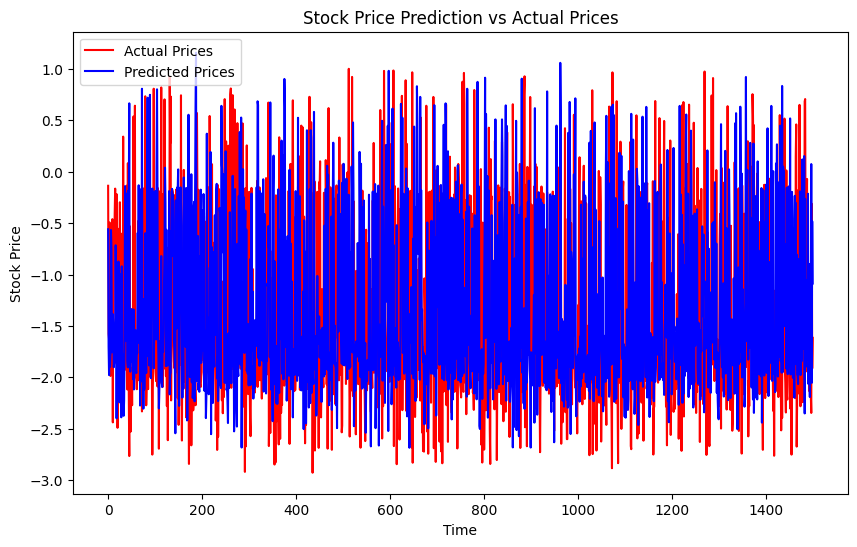

In [73]:
import matplotlib.pyplot as plt

# Plot the rescaled predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(actuals_rescaled, label='Actual Prices', color='red')
plt.plot(predictions_rescaled, label='Predicted Prices', color='blue')
plt.title('Stock Price Prediction vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## Calcuate Evaluation Metrics

In [74]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE between rescaled predictions and actual values
rmse = np.sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print(f'RMSE: {rmse}')


RMSE: 1.2635195943239885


In [75]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
print(f'MAE: {mae}')

# Calculate R-Squared
r2 = r2_score(actuals_rescaled, predictions_rescaled)
print(f'R²: {r2}')


MAE: 0.9844395655297363
R²: -0.8972203486770098
